In [153]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import numpy as np
from parse_reports import *
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# --- Power Report ---
power_report_path = "/home/lquizon/lawrence-workspace/SRAM_test/qrAcc2/qr_acc_2_digital/results/base_with_sram_1/reports/power_qr_acc_top.txt"
df_power = parse_report(power_report_path)
df_power_level1 = df_power[df_power['hierarchy_level'] == 1]

# --- Area Report ---
area_report_path = "/home/lquizon/lawrence-workspace/SRAM_test/qrAcc2/qr_acc_2_digital/results/base_with_sram_1/reports/area_qr_acc_top.txt"
df_area = parse_report(area_report_path)
df_area_level1 = df_area[df_area['hierarchy_level'] == 1]

df_power_level1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,hierarchy,hierarchy_clean,module_name,instance_name,switch_power,int_power,leak_power,total_power,percentage,hierarchy_level,line_number
1,u_piso_write_queue (piso_write_queue_numParall...,u_piso_write_queue,piso,u_piso_write_queue,1.270000e-05,0.001072,2.874600e-05,1.113000e-03,2.5,1,36
2,u_mm_output_aligner (mm_output_aligner_numCols...,u_mm_output_aligner,mm,u_mm_output_aligner,0.000000e+00,0.000000,1.114100e-05,1.110000e-05,0.0,1,38
3,u_output_scaler_set (output_scaler_set_numElem...,u_output_scaler_set,output,u_output_scaler_set,1.530000e-04,0.003779,4.040660e-04,4.336000e-03,9.7,1,40
260,u_feature_loader (feature_loader_inputWidth256...,u_feature_loader,feature,u_feature_loader,6.790000e-06,0.000561,3.840400e-05,6.060000e-04,1.4,1,554
261,u_padder (padder_elementWidth8_numElements32),u_padder,padder,u_padder,0.000000e+00,0.000000,3.140000e-07,3.140000e-07,0.0,1,556
262,u_activation_buffer (activation_buffer_addrWid...,u_activation_buffer,activation,u_activation_buffer,6.700000e-06,0.004354,4.449100e-05,4.406000e-03,9.8,1,558
328,u_wsacc (wsacc_pe_cluster_numPes32_windowEleme...,u_wsacc,wsacc,u_wsacc,9.350000e-06,0.000690,4.189500e-05,7.410000e-04,1.7,1,658
361,u_seq_acc (seq_acc_maxInputBits8_inputElements...,u_seq_acc,seq,u_seq_acc,3.202700e-02,0.001316,4.143800e-05,3.338500e-02,74.5,1,724
364,u_qracc_controller (qracc_controller_numScaler...,u_qracc_controller,qracc,u_qracc_controller,9.790000e-07,0.000079,5.176000e-06,8.550000e-05,0.2,1,730
365,u_csr (qracc_csr_32_16_00000010),u_csr,qracc,u_csr,2.250000e-06,0.000124,2.235000e-06,1.280000e-04,0.3,1,731


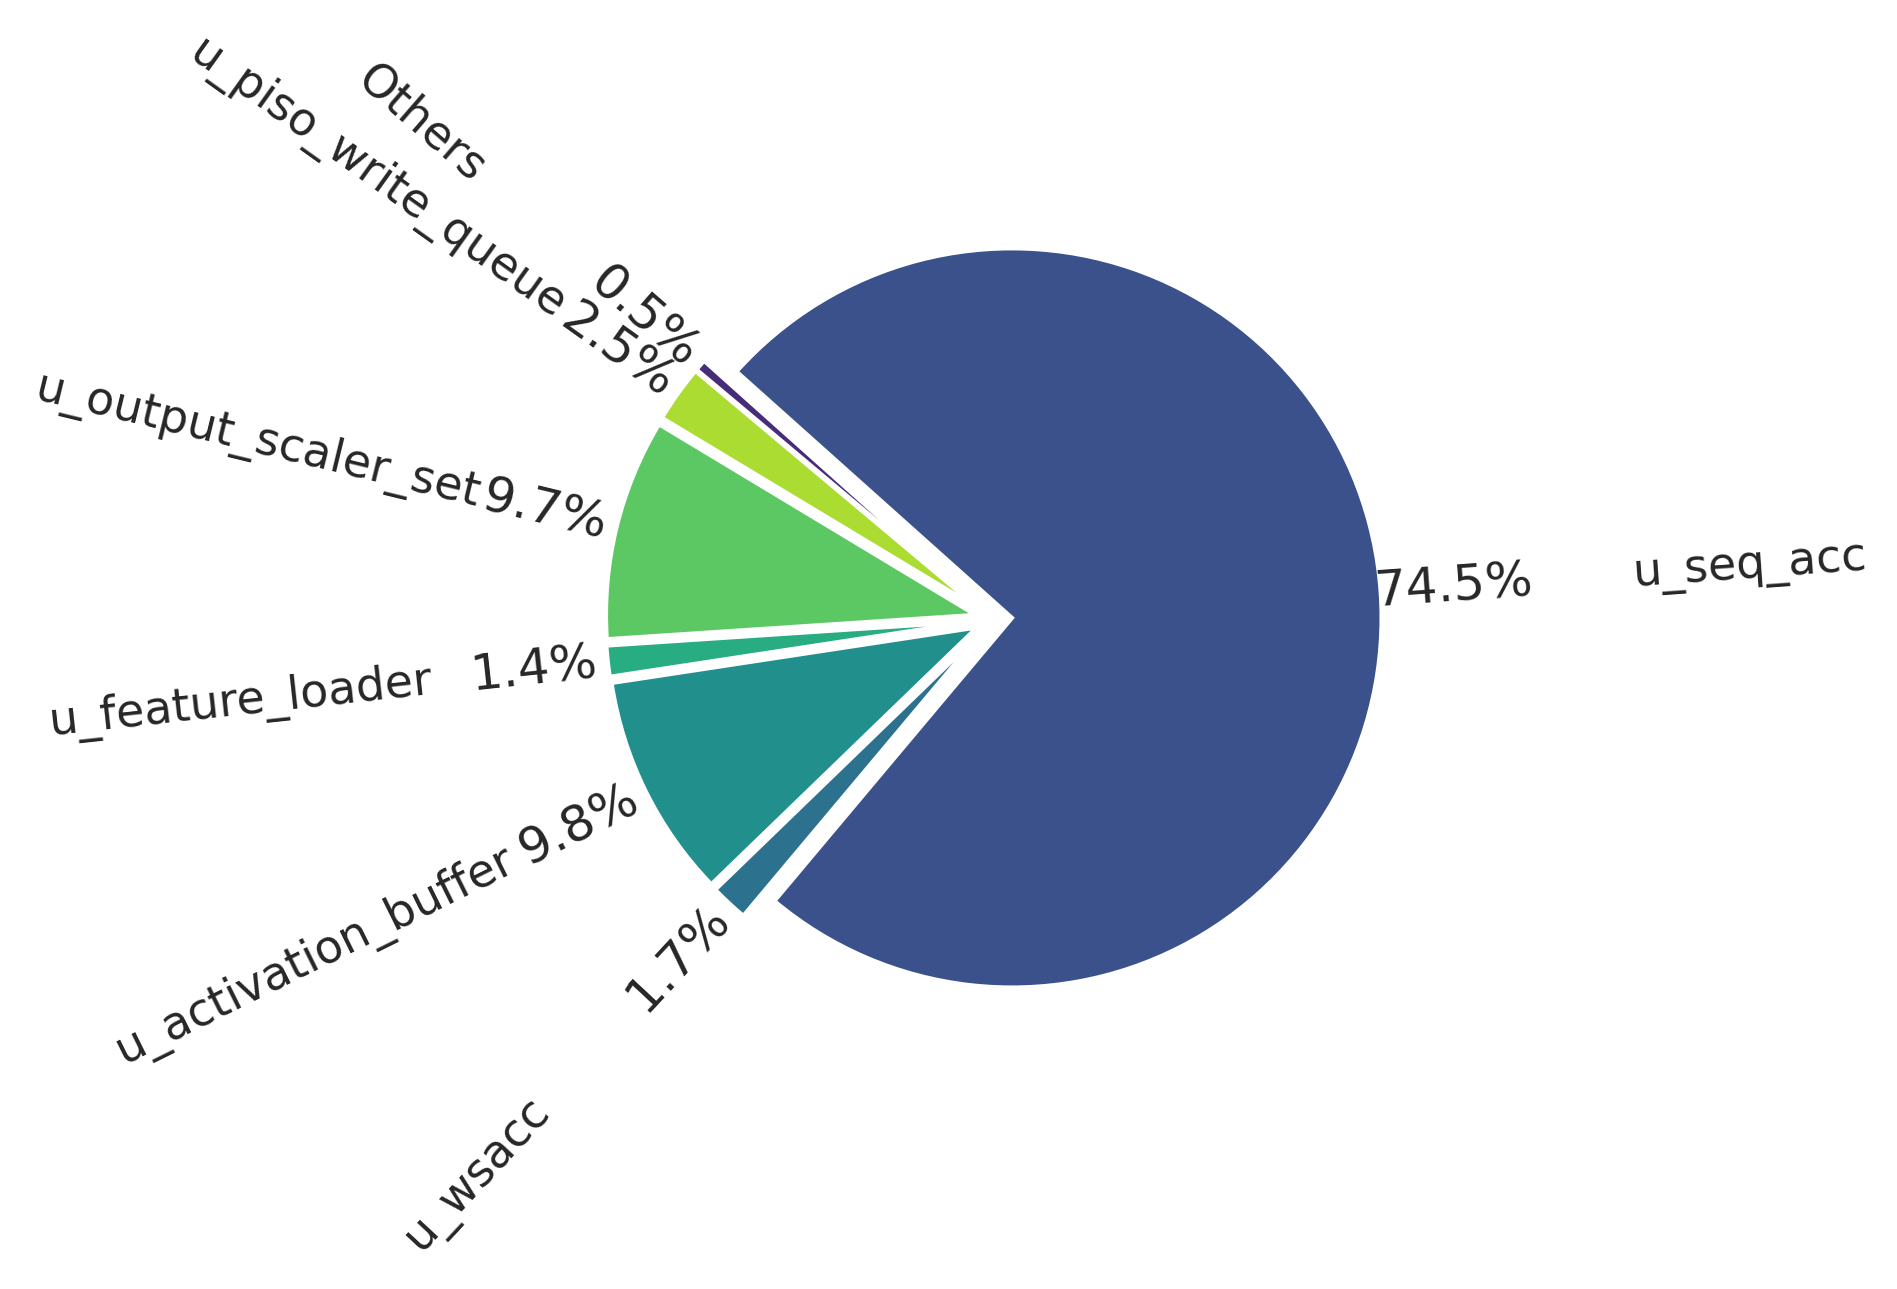

In [154]:
plot_power_pie(df_power_level1)
plt.savefig('power_pie.svg', bbox_inches='tight')

/home/lquizon/lawrence-workspace/SRAM_test/qrAcc2/qr_acc_2_digital/results/parse_reports.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='hierarchy_clean', y='total_power', palette='viridis', ax=ax)


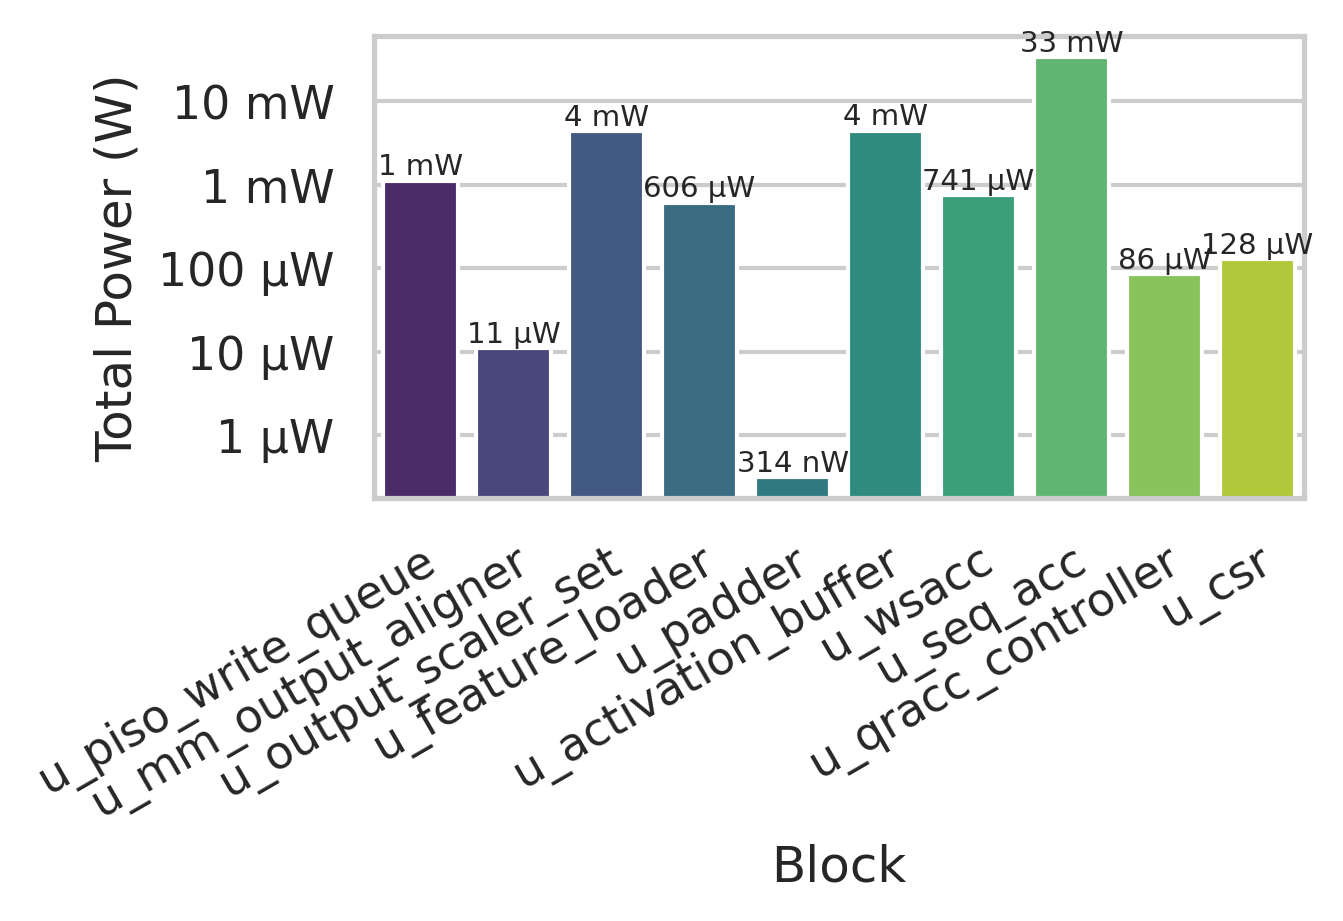

In [159]:
plot_power_report(df_power_level1)
plt.savefig('power_bar.svg', bbox_inches='tight')

In [ ]:
dfa = parse_area_report("/home/lquizon/lawrence-workspace/SRAM_test/qrAcc2/qr_acc_2_digital/results/base_with_sram_1/reports/area_qr_acc_top.txt")
dfa_level1 = dfa[dfa['hierarchy_level'] == 1]
dfa_level1

,hierarchy,hierarchy_clean,module_name,instance_name,total_area,percentage,combi_area,noncombi_area,blackbox_area,design,hierarchy_level,line_number
0,u_activation_buffer,u_activation_buffer,u_activation_buffer,u_activation_buffer,394292.8593,46.9,260.3736,375.6312,0.0,activation_buffer_addrWidth32_dataSize8_interf...,1,46
66,u_csr,u_csr,u_csr,u_csr,1189.1160,0.1,443.7696,745.3464,0.0,qracc_csr_32_16_00000010,1,176
67,u_feature_loader,u_feature_loader,u_feature_loader,u_feature_loader,29229.6338,3.5,25862.1075,3367.5263,0.0,feature_loader_inputWidth256_addrWidth32_eleme...,1,177
68,u_mm_output_aligner,u_mm_output_aligner,u_mm_output_aligner,u_mm_output_aligner,9110.5009,1.1,9110.5009,0.0000,0.0,mm_output_aligner_numColsPerBank32_elementBits...,1,178
69,u_output_scaler_set,u_output_scaler_set,u_output_scaler_set,u_output_scaler_set,312170.1263,37.1,9020.3689,22496.9464,0.0,output_scaler_set_numElements256_inputWidth16_...,1,179
326,u_padder,u_padder,u_padder,u_padder,183.9528,0.0,183.9528,0.0000,0.0,padder_elementWidth8_numElements32,1,692
327,u_piso_write_queue,u_piso_write_queue,u_piso_write_queue,u_piso_write_queue,19663.2528,2.3,13232.2130,6431.0398,0.0,piso_write_queue_numParallelIn8_writeInterface...,1,693
328,u_qracc_controller,u_qracc_controller,u_qracc_controller,u_qracc_controller,4019.2608,0.5,3544.2408,475.0200,0.0,qracc_controller_numScalers256_numRows256_inte...,1,694
329,u_seq_acc,u_seq_acc,u_seq_acc,u_seq_acc,22844.9471,2.7,12623.2825,8138.3278,0.0,seq_acc_maxInputBits8_inputElements256_outputE...,1,695
332,u_wsacc,u_wsacc,u_wsacc,u_wsacc,34076.9251,4.1,361.2240,767.3400,0.0,wsacc_pe_cluster_numPes32_windowElements9_outp...,1,698


/home/lquizon/lawrence-workspace/SRAM_test/qrAcc2/qr_acc_2_digital/results/parse_reports.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='hierarchy_clean', y='total_area', palette='plasma', ax=ax)


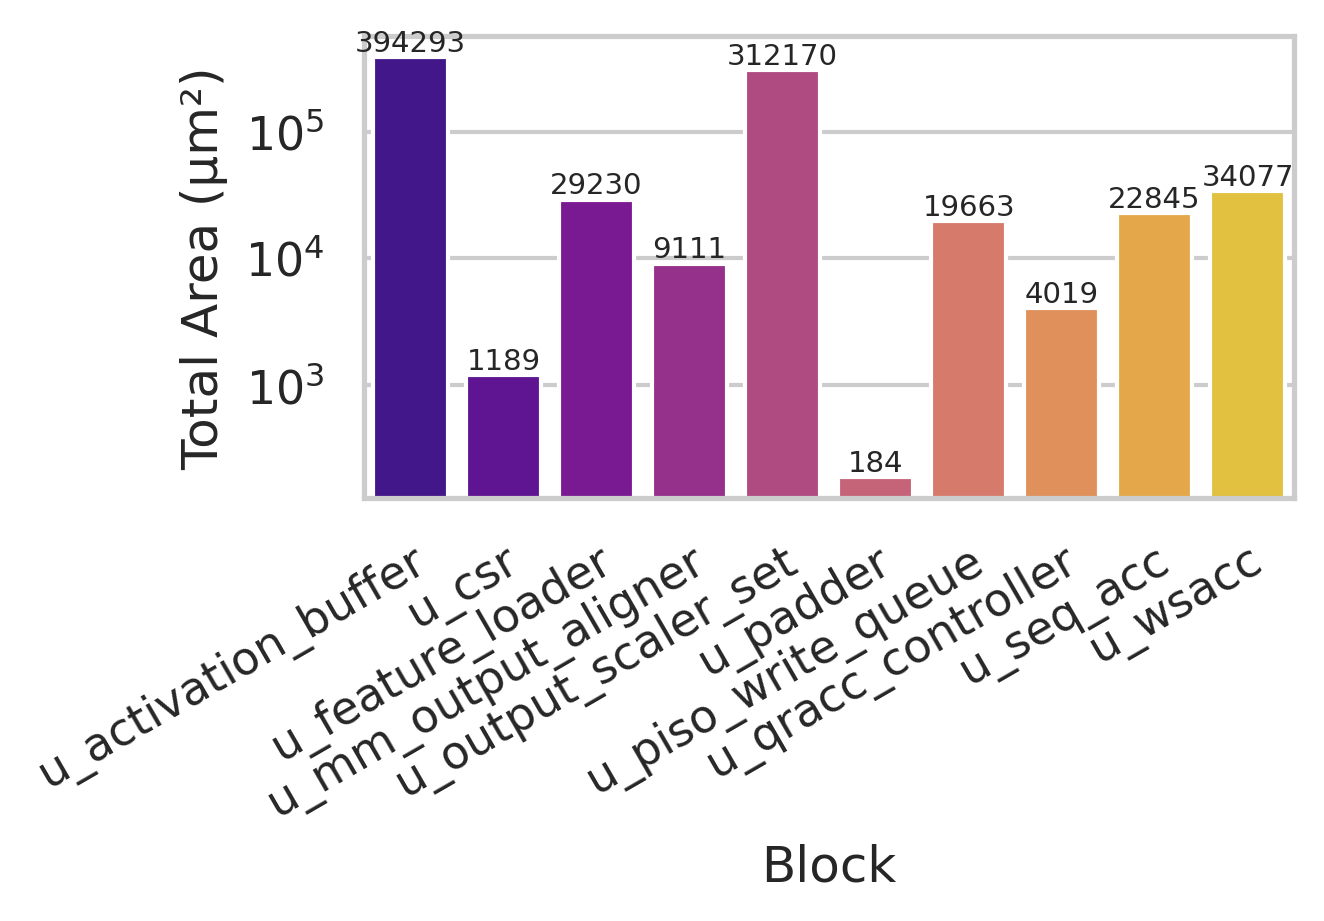

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)
plot_area_report(df_area_level1, ax=ax)
plt.savefig('area_bar.svg', bbox_inches='tight')

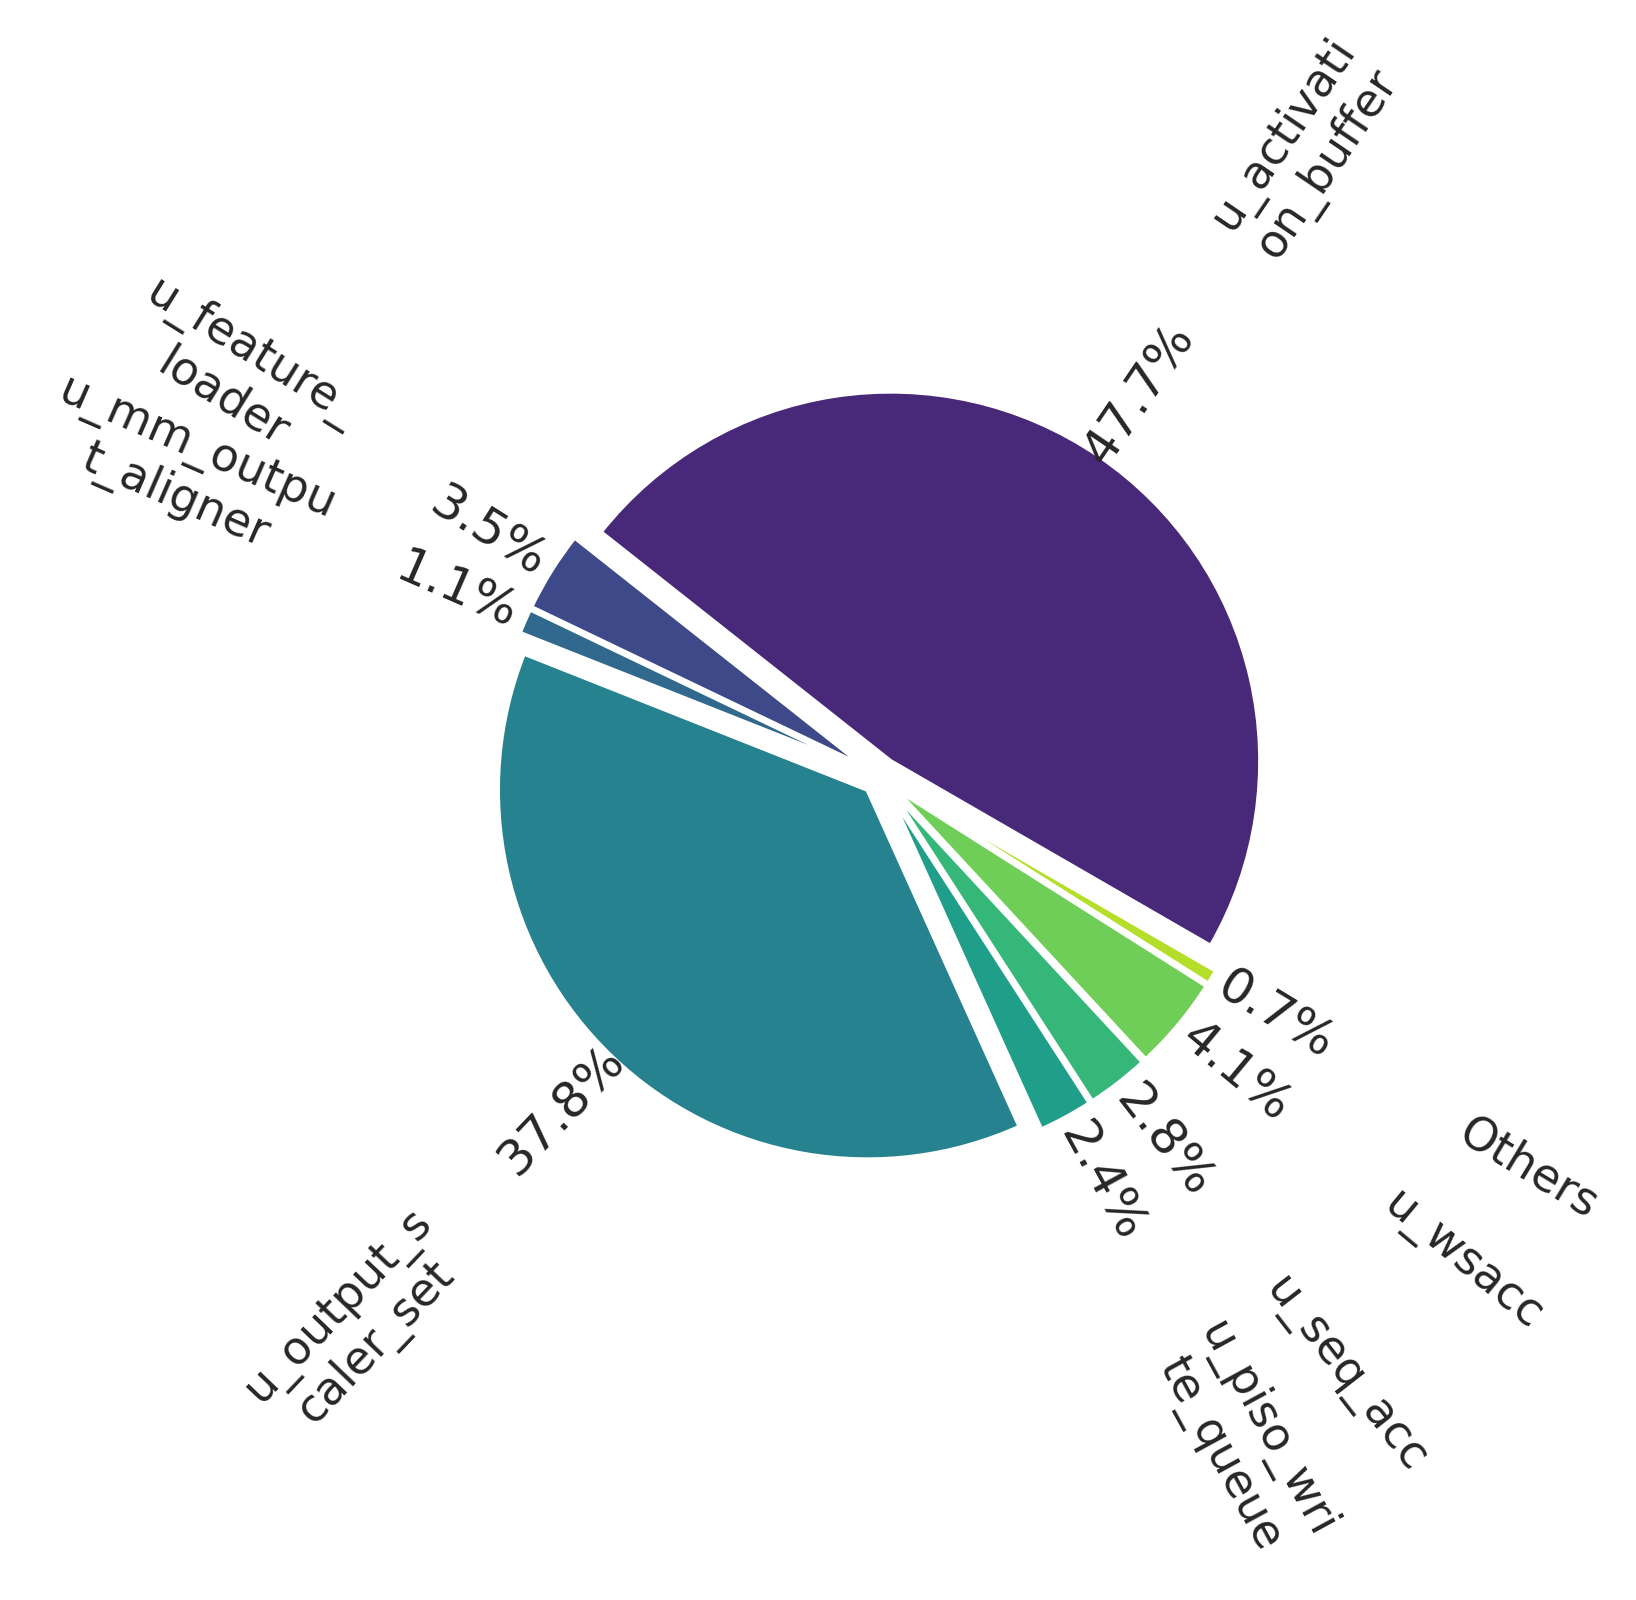

In [ ]:
plot_area_pie(df_area_level1,-30)
plt.savefig('area_pie.svg', bbox_inches='tight')